Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (10000, 32, 32, 3)
Test data shape: (2000, 32, 32, 3)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Total Parameters: 4,214,829

Training EfficientNetB0 model (memory-optimized)...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.7167 - loss: 0.8610 - val_accuracy: 0.8310 - val_loss: 0.5008 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8606 - loss: 0.4309 - val_accuracy: 0.8320 - val_loss: 0.5013 - learning_rate: 0.0010
Epoch 3/10
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8775 - loss: 0.3532
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8775 - loss: 0.3532 - val_accuracy: 0.8320 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9104 - loss: 0.2612 - 

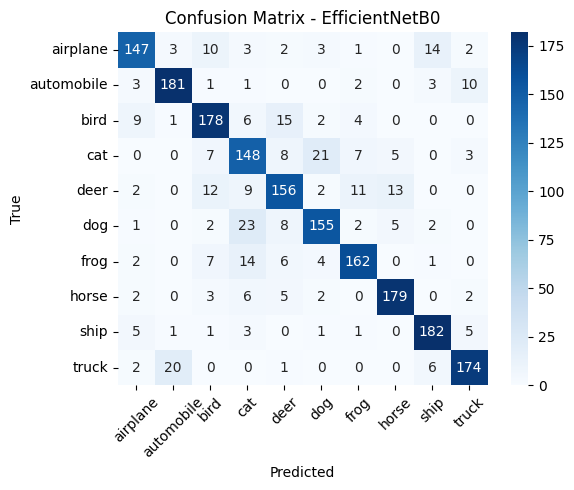


🔧 Optional Fine-Tuning (reduce memory further by skipping this)...
Unfreezing 24 layers out of 238

Fine-tuning for 3 epochs...
Epoch 5/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.6819 - loss: 0.9476 - val_accuracy: 0.7935 - val_loss: 0.6177 - learning_rate: 1.0000e-05
Epoch 6/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7500 - loss: 0.7458 - val_accuracy: 0.8150 - val_loss: 0.5634 - learning_rate: 1.0000e-05
Epoch 7/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7783 - loss: 0.6727 - val_accuracy: 0.8190 - val_loss: 0.5413 - learning_rate: 1.0000e-05
Epoch 8/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7977 - loss: 0.6058 - val_accuracy: 0.8190 - val_loss: 0.5230 - learning_rate: 1.0000e-05
Epoch 9/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7968 - loss: 0.5945 - val_accuracy: 0.8300 - val_loss: 0.5090 - learning_rate: 1.0000e-05
Epoch 10/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.80

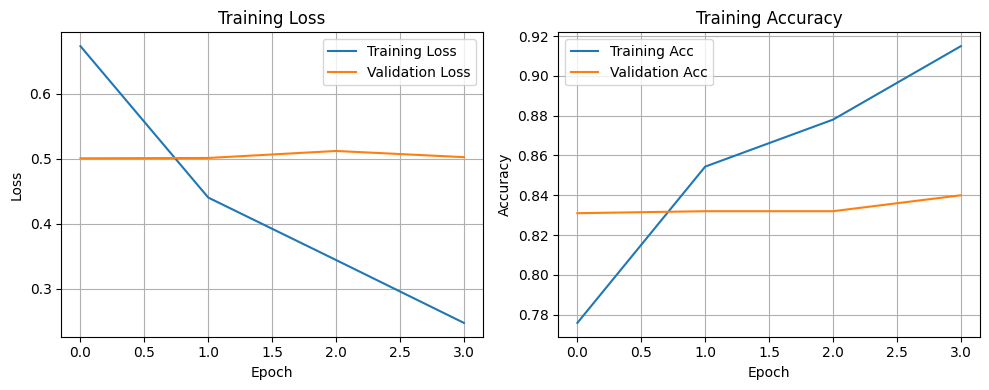


✅ Memory-optimized training completed!

Memory Optimization Summary:
• Used 10,000 training samples (instead of 50,000)
• Used 2,000 test samples (instead of 10,000)
• Input size: 96x96 (instead of 224x224)
• Batch size: 8 (instead of 16+)
• Simplified model architecture
• Total parameters: 4,214,829


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc

# Memory optimization settings
tf.config.experimental.enable_memory_growth = True
tf.keras.backend.clear_session()

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use only a subset of data to reduce memory usage
SUBSET_SIZE = 10000  # Use only 10k samples instead of 50k
TEST_SIZE = 2000     # Use only 2k test samples instead of 10k

# Randomly sample subset
np.random.seed(42)
train_indices = np.random.choice(len(X_train), SUBSET_SIZE, replace=False)
test_indices = np.random.choice(len(X_test), TEST_SIZE, replace=False)

X_train = X_train[train_indices]
y_train = y_train[train_indices]
X_test = X_test[test_indices]
y_test = y_test[test_indices]

# Normalize and flatten labels
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Memory-optimized parameters
IMG_SIZE = 96        # Smaller input size to save memory
BATCH_SIZE = 8       # Smaller batch size
EPOCHS = 10          # Fewer epochs
NUM_CLASSES = 10

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image * 255.0)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Create smaller datasets with more aggressive prefetching
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(preprocess, num_parallel_calls=2) \
    .shuffle(1000) \
    .batch(BATCH_SIZE) \
    .prefetch(1)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(preprocess, num_parallel_calls=2) \
    .batch(BATCH_SIZE) \
    .prefetch(1)

# Clear variables to free memory
del X_train, X_test, y_train, y_test
gc.collect()

# Load EfficientNetB0 with smaller input
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# Simpler model architecture to save memory
model_EfficientNet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # Smaller dense layer
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile with memory-efficient settings
model_EfficientNet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nTotal Parameters: {model_EfficientNet.count_params():,}")

# Memory-efficient callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train the model
print("\nTraining EfficientNetB0 model (memory-optimized)...")
history = model_EfficientNet.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)

# Efficient evaluation
print("\nEvaluating model...")

# Process predictions in smaller chunks to save memory
y_pred_list = []
y_true_list = []

for batch_x, batch_y in test_dataset:
    # Get predictions for this batch
    batch_pred = model_EfficientNet.predict(batch_x, verbose=0)
    y_pred_list.append(batch_pred.argmax(axis=1))
    y_true_list.append(tf.argmax(batch_y, axis=1).numpy())

# Concatenate results
y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Clear temporary variables
del y_pred_list, y_true_list
gc.collect()

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n🔍 EfficientNetB0 Results (Memory-Optimized):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Optional: Show classification report (comment out if not needed)
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Memory-efficient confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))  # Smaller figure
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - EfficientNetB0')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# OPTIONAL FINE-TUNING (comment out if too slow)
print("\n🔧 Optional Fine-Tuning (reduce memory further by skipping this)...")

# Unfreeze only the very last layers for minimal memory impact
total_layers = len(base_model.layers)
fine_tune_at = int(total_layers * 0.9)  # Unfreeze only last 10%

base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfreezing {total_layers - fine_tune_at} layers out of {total_layers}")

# Recompile
model_EfficientNet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for fewer epochs
fine_tune_epochs = 3
print(f"\nFine-tuning for {fine_tune_epochs} epochs...")

history_ft = model_EfficientNet.fit(
    train_dataset,
    epochs=EPOCHS + fine_tune_epochs,
    initial_epoch=len(history.history['loss']),
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)

# Re-evaluate after fine-tuning
print("\nRe-evaluating after fine-tuning...")
y_pred_ft_list = []
for batch_x, batch_y in test_dataset:
    batch_pred = model_EfficientNet.predict(batch_x, verbose=0)
    y_pred_ft_list.append(batch_pred.argmax(axis=1))

y_pred_ft = np.concatenate(y_pred_ft_list)
acc_ft = accuracy_score(y_true, y_pred_ft)

print(f"\n🔍 After Fine-tuning:")
print(f"Accuracy: {acc_ft:.4f} (Improvement: {acc_ft - acc:+.4f})")

# Simple training history plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Clean up memory
tf.keras.backend.clear_session()
gc.collect()

print("\n✅ Memory-optimized training completed!")
print(f"\nMemory Optimization Summary:")
print(f"• Used {SUBSET_SIZE:,} training samples (instead of 50,000)")
print(f"• Used {TEST_SIZE:,} test samples (instead of 10,000)")
print(f"• Input size: {IMG_SIZE}x{IMG_SIZE} (instead of 224x224)")
print(f"• Batch size: {BATCH_SIZE} (instead of 16+)")
print(f"• Simplified model architecture")
print(f"• Total parameters: {model_EfficientNet.count_params():,}")